In [1]:
# adhunter_v2
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
# Before running this code:
#
# A hmmer search was performed using the y1000+ genomes
#       Build hmm profile from ygob alignment of Ino2 genes: 
#               hmmbuild <hmmprofile> <ygob_alignment>
#       Run hmm search on genomes from y1000+:
#           cat ../genome_data/y1000p_pep_files_modified/*modified.pep | hmmsearch -o Ino4_search.out -A Ino4_search.align --tblout Ino4_search.tsv Ino4.hmm -
# 
# Extract significant genes found in hmmsearch using the get_gene_names function
# 
# Get sequences for significant genes
#       while IFS=, read -r gene species; do   species=$(echo "$species" | tr -d '\r');  grep -A 1 $gene ../GCN4_evolution/genome_data/y1000p_pep_files_modified/${species}_modified.pep; done < ino4_gene_names.csv > ino4_orthologs.fasta
# 
# Use the fasta file to identify domains with: https://www.ncbi.nlm.nih.gov/Structure/bwrpsb/bwrpsb.cgi
#
# Perform a reverse blast on the identified sequences with: 
#       ncbi-blast-2.15.0+/bin/blastp -query ino4_orthologs.fasta -db saccharomyces_cerevisiae.final.blastdb -evalue 0.001 -outfmt 6 > reciprocal_blast_ino4.txt

In [3]:
# Used to extract gene names
def get_gene_names(in_file, out_file):
    with open(in_file, "r") as f:
        lines = f.readlines()
        
    genes = [line for line in lines if not line.startswith("#")]
    names = [gene.split()[0] for gene in genes]

    e_vals = [float(gene.split()[4]) for gene in genes]
    scores = [float(gene.split()[5]) for gene in genes]

    split_names = [name.split("_") for name in names]

    genes = [split_name[0] for split_name in split_names]
    species = ["_".join(split_name[1:]) for split_name in split_names]

    genes_species = pd.DataFrame((genes, species, e_vals, scores)).T
    genes_species.columns = ["gene","species","evalue", "scores"]
    genes_species = genes_species[genes_species["evalue"] < 0.001]

    genes_species[["gene", "species"]].to_csv(out_file, index=False, header=None)

# Domain filtering

In [4]:
all_lines = []

# Read in domain file
for i in range(1,3):
    domain_file = f"../Met4/Met4_domains_{i}.txt"
    with open(domain_file, "r") as f:
        lines = f.readlines()

    lines = [line.strip().split('\t') for line in lines if not line.startswith("#")]
    all_lines = all_lines + (lines[2:])

domains = pd.DataFrame(all_lines, columns=lines[1])
domains["name"] = [s.split('>')[-1] for s in domains["Query"]]
domains

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name
0,Q#5 - >g001795.m1_saccharomyces_kudriavzevii.f...,superfamily,473870,606,644,2.79569e-07,47.5259,cl21462,bZIP superfamily,N,-,g001795.m1_saccharomyces_kudriavzevii.final
1,Q#7 - >g001826.m1_saccharomyces_eubayanus.final,superfamily,473870,612,650,3.71217e-07,47.1407,cl21462,bZIP superfamily,N,-,g001826.m1_saccharomyces_eubayanus.final
2,Q#8 - >g001710.m1_saccharomyces_uvarum.final,superfamily,473870,610,648,1.99565e-07,47.9111,cl21462,bZIP superfamily,N,-,g001710.m1_saccharomyces_uvarum.final
3,Q#9 - >g000192.m1_yHMPu5000034678_lachancea_th...,superfamily,473870,502,539,3.51945e-07,47.1407,cl21462,bZIP superfamily,N,-,g000192.m1_yHMPu5000034678_lachancea_thermotol...
4,Q#10 - >g001621.m1_yHMPu5000034863_zygosacchar...,superfamily,473870,593,631,3.52814e-06,44.4443,cl21462,bZIP superfamily,N,-,g001621.m1_yHMPu5000034863_zygosaccharomyces_r...
...,...,...,...,...,...,...,...,...,...,...,...,...
1966,Q#902 - >g000476.m1_yHMPu5000035278_tortispora...,specific,269853,170,223,9.94045e-21,82.579,cd14705,bZIP_Zip1,-,cl21462,g000476.m1_yHMPu5000035278_tortispora_phaffii_...
1967,Q#903 - >g003574.m1_yHMPu5000034730_myxozyma_m...,specific,269853,201,255,1.39258e-24,93.3646,cd14705,bZIP_Zip1,-,cl21462,g003574.m1_yHMPu5000034730_myxozyma_monticola_...
1968,Q#903 - >g003574.m1_yHMPu5000034730_myxozyma_m...,superfamily,442308,233,280,0.00972355,34.5623,cl43780,ZapB superfamily,C,-,g003574.m1_yHMPu5000034730_myxozyma_monticola_...
1969,Q#904 - >g001644.m1_yHMPu5000026279_Ambrosiozy...,specific,269853,108,162,1.94225e-12,60.6227,cd14705,bZIP_Zip1,-,cl21462,g001644.m1_yHMPu5000026279_Ambrosiozyma_monosp...


In [5]:
# No cerevisiae domains --> Don't filter on domains
domains[["saccharomyces_cerevisiae" in s for s in domains["name"]]]

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name


In [6]:
# Look at top most common domains
domains["Short name"].value_counts()

Short name
bZIP_Zip1                      1605
bZIP superfamily                228
PRK03918 superfamily              9
ZapE superfamily                  9
YurZ                              8
                               ... 
ATG16 superfamily                 1
ser_rich_anae_1 superfamily       1
PTZ00341 superfamily              1
dermokine superfamily             1
Peptidase_S21 superfamily         1
Name: count, Length: 66, dtype: int64

In [7]:
# Get gene and species DF
genes_species = pd.read_csv("../Met4/Met4_gene_names.csv", header=None)
genes_species.columns = ["gene", "species"]
genes_species

,gene,species
0,YNL103W,saccharomyces_cerevisiae.sgd
1,g001856.m1,saccharomyces_cerevisiae.final
2,g001797.m1,saccharomyces_mikatae.final
3,g001803.m1,saccharomyces_paradoxus.final
4,g001795.m1,saccharomyces_kudriavzevii.final
...,...,...
1901,g005340.m1,yHMPu5000034889_Ogataea_salicorniae_SPADES.final
1902,g000476.m1,yHMPu5000035278_tortispora_phaffii_170713.final
1903,g003574.m1,yHMPu5000034730_myxozyma_monticola_201018.final
1904,g001644.m1,yHMPu5000026279_Ambrosiozyma_monospora_SPADES....


Text(0.5, 0, 'Number of Met4 orthologs per species')

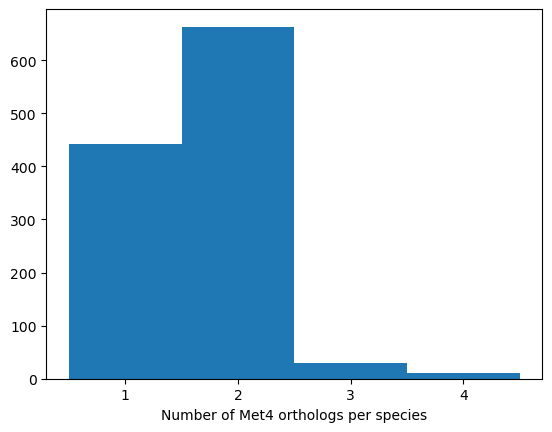

In [8]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5])
plt.xticks([1,2,3,4])
plt.xlabel("Number of Met4 orthologs per species")

# Reverse blast

In [9]:
# Read in blast data
blast_hits = pd.read_table("../Met4/blast_Met4.txt", header=None)
blast_hits.columns = ["gene_species_name", "blast_hit_gene_name","percent_identical", "alignment_length","num_mismatch","num_gaps","start_of_align_query","end_of_align_query","start_of_align_subj","end_of_align_subj","evalue","bitscore"]
blast_hits

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
0,YNL103W_saccharomyces_cerevisiae.sgd,g001856.m1,100.000,60,0,0,1,60,1,60,2.810000e-35,122.0
1,g001856.m1_saccharomyces_cerevisiae.final,g001856.m1,100.000,672,0,0,1,672,1,672,0.000000e+00,1355.0
2,g001797.m1_saccharomyces_mikatae.final,g001856.m1,76.316,684,147,8,1,681,1,672,0.000000e+00,883.0
3,g001803.m1_saccharomyces_paradoxus.final,g001856.m1,85.714,679,90,3,1,679,1,672,0.000000e+00,990.0
4,g001795.m1_saccharomyces_kudriavzevii.final,g001856.m1,74.889,677,161,5,1,673,1,672,0.000000e+00,850.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4794,g000476.m1_yHMPu5000035278_tortispora_phaffii_...,g005546.m1,30.769,78,54,0,170,247,109,186,3.000000e-04,38.5
4795,g003574.m1_yHMPu5000034730_myxozyma_monticola_...,g005546.m1,31.633,98,65,1,169,266,78,173,1.610000e-06,45.4
4796,g003574.m1_yHMPu5000034730_myxozyma_monticola_...,g004283.m1,44.828,58,25,1,204,261,231,281,5.190000e-04,38.9
4797,g001644.m1_yHMPu5000026279_Ambrosiozyma_monosp...,g005546.m1,40.000,55,33,0,108,162,108,162,1.900000e-04,39.3


Text(0.5, 0, 'Number of blast hits per gene')

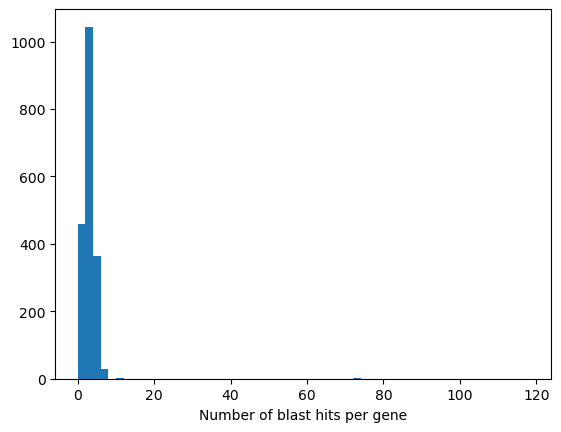

In [10]:
plt.hist(blast_hits["gene_species_name"].value_counts(), bins=np.arange(0,120,2))
plt.xlabel("Number of blast hits per gene")

In [11]:
# Sorts first on species, then on evalue (smallest first)
blast_hits = blast_hits.sort_values(["gene_species_name", "evalue"])

# Only keep the most significant blast hit
top_blast_hit = blast_hits.drop_duplicates("gene_species_name", keep="first")
top_blast_hit

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
0,YNL103W_saccharomyces_cerevisiae.sgd,g001856.m1,100.000,60,0,0,1,60,1,60,2.810000e-35,122.0
4101,g000003.m1_yHMPu5000034751_dipodascopsis_tothi...,g005546.m1,37.500,80,43,2,217,289,108,187,4.740000e-05,41.2
242,g000003.m1_yHMPu5000035699_cyberlindnera_maclu...,g001856.m1,44.578,83,16,1,20,72,82,164,8.510000e-13,67.8
1826,g000011.m1_yHMPu5000038323_scheffersomyces_lig...,g001856.m1,38.400,125,47,5,15,109,86,210,7.870000e-10,58.2
320,g000016.m1_yHMPu5000035271_wickerhamomyces_bov...,g001856.m1,39.091,110,27,2,4,73,77,186,3.020000e-13,68.9
...,...,...,...,...,...,...,...,...,...,...,...,...
3715,g010915.m1_yHMPu5000034630_Magnusiomyces_magnu...,g005546.m1,33.333,75,50,0,362,436,109,183,2.160000e-05,43.1
2976,g011348.m1_yHMPu5000041701_Candida_jeffriesii_...,g001856.m1,39.241,79,25,1,5,60,86,164,3.640000e-09,51.6
508,g012956.m1_yHMPu5000035269_wickerhamomyces_cif...,g001856.m1,42.500,80,16,1,8,57,85,164,7.120000e-12,64.7
4002,g014158.m1_yHMPu5000035269_wickerhamomyces_cif...,g005546.m1,33.028,109,68,1,96,199,79,187,2.290000e-07,47.0


In [12]:
# Filter for genes with top blast hit to Met4
top_blast_hit_met4 = top_blast_hit[top_blast_hit["blast_hit_gene_name"] == "g001856.m1"]
top_blast_hit_met4

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
0,YNL103W_saccharomyces_cerevisiae.sgd,g001856.m1,100.000,60,0,0,1,60,1,60,2.810000e-35,122.0
242,g000003.m1_yHMPu5000035699_cyberlindnera_maclu...,g001856.m1,44.578,83,16,1,20,72,82,164,8.510000e-13,67.8
1826,g000011.m1_yHMPu5000038323_scheffersomyces_lig...,g001856.m1,38.400,125,47,5,15,109,86,210,7.870000e-10,58.2
320,g000016.m1_yHMPu5000035271_wickerhamomyces_bov...,g001856.m1,39.091,110,27,2,4,73,77,186,3.020000e-13,68.9
1460,g000019.m1_yHMPu5000037925_candida_aglyptinia_...,g001856.m1,45.333,75,16,2,10,59,90,164,6.940000e-10,57.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2367,g009191.m1_yHMPu5000041803_Metschnikowia_zizyp...,g001856.m1,37.975,79,20,2,4,53,86,164,5.170000e-07,50.1
1407,g009343.m1_yHMPu5000038379_candida_lidongshani...,g001856.m1,40.506,79,22,2,8,61,86,164,1.080000e-08,54.3
2976,g011348.m1_yHMPu5000041701_Candida_jeffriesii_...,g001856.m1,39.241,79,25,1,5,60,86,164,3.640000e-09,51.6
508,g012956.m1_yHMPu5000035269_wickerhamomyces_cif...,g001856.m1,42.500,80,16,1,8,57,85,164,7.120000e-12,64.7


In [13]:
genes_species["gene_species_name"] = genes_species["gene"] + "_" + genes_species["species"]

In [14]:
# Merge blast df with filtered domain df
top_blast_hit_met4 = top_blast_hit_met4.merge(genes_species, on="gene_species_name")

In [15]:
top_blast_hit_met4["species"].value_counts()

species
yHMPu5000035627_zygosaccharomyces_pseudobailii_201018.haplomerger2.final    3
yHMPu5000035004_candida_albicans_190924.final                               3
yHMPu5000035269_wickerhamomyces_ciferrii_170307.final                       2
yHMPu5000034887_ogataea_trehaloabstinens_160519.final                       2
yHMPu5000035013_candida_panamericana_160519.final                           2
                                                                           ..
yHMPu5000034988_candida_fructus_160519.final                                1
yHMPu5000034890_ogataea_ramenticola_160519.final                            1
yHMPu5000034995_candida_parapsilosis_170307.final                           1
yHDO565_zygosaccharomyces_gambellarensis_180604.final                       1
yHMPu5000034607_saccharomycopsis_capsularis_180604.final                    1
Name: count, Length: 847, dtype: int64

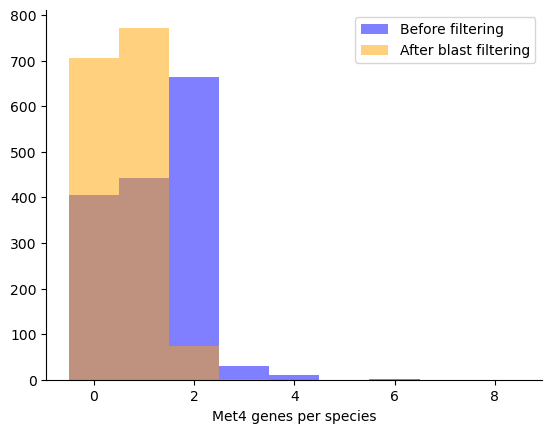

In [16]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), label="Before filtering", color="blue", alpha = 0.5, bins=np.arange(-0.5,9,1))
plt.hist([0] * (1553 - len(set(genes_species["species"]))) , color="blue", alpha=0.5, bins=np.arange(-0.5,9,1))

plt.hist(top_blast_hit_met4.value_counts("species"), label="After blast filtering", alpha=0.5, color='orange',bins=np.arange(-0.5,9,1))
plt.hist([0] * (1553 - len(set(top_blast_hit_met4["species"]))), alpha=0.5, color='orange', bins=np.arange(-0.5,9,1))

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['top'].set_visible(False) 

plt.xlabel("Met4 genes per species")
plt.legend()

In [17]:
# Read fasta sequences
with open("../Met4/Met4_orthologs.fasta", "r") as f:
    lines = f.readlines()

seqs = []
names = []
seq = ""

for line in lines:
    if line.startswith('>'):
        names.append(line.strip().replace(">", ""))
        if len(seq) > 0:
            seqs.append(seq)
            seq = ""
    else:
        seq += line.strip()
seqs.append(seq)

# Write to a csv file
met4_df = pd.DataFrame({"name" : names, "aa_seq" : seqs})
met4_df.to_csv("../Met4/Met4_orthologs.csv", index=False)
met4_df

,name,aa_seq
0,YNL103W_saccharomyces_cerevisiae.sgd,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...
1,g001856.m1_saccharomyces_cerevisiae.final,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...
2,g001797.m1_saccharomyces_mikatae.final,MKQEQSHEDNSYATEFINLFGKGTGTHVSSNDSGNNGMGSVNTLEQ...
3,g001803.m1_saccharomyces_paradoxus.final,MKQEQSREGDSYSTEFINLFGKETATHASNNNGANNNGMGSATTLD...
4,g001795.m1_saccharomyces_kudriavzevii.final,MKQEHSHEDDSYTAEFINLFGKDTATHASSDNNNNSANNNGMGSAN...
...,...,...
1899,g005340.m1_yHMPu5000034889_Ogataea_salicorniae...,MGSNIIPKESKNKESNFNLDDFDFDFYQSSTISPSGPSDDLSLFMN...
1900,g000476.m1_yHMPu5000035278_tortispora_phaffii_...,MYSRPLNVSQYIATLNSLDPVASVKEEEDLSLFTNAEFFDFDVGQS...
1901,g003574.m1_yHMPu5000034730_myxozyma_monticola_...,MAYSSHRGVNVSQYIANLNSVEPLDFPAAAKDDLSLFANTHFFDFD...
1902,g001644.m1_yHMPu5000026279_Ambrosiozyma_monosp...,MQGSSSNHFLQQQQLERLQQQQHQYLPLLNVSRQPSISGASTPDLG...


In [18]:
# Merge sequence df with filtered df
met4_filtered_df = met4_df.merge(top_blast_hit_met4, left_on="name", right_on="gene_species_name")
met4_filtered_df

,name,aa_seq,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore,gene,species
0,YNL103W_saccharomyces_cerevisiae.sgd,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,YNL103W_saccharomyces_cerevisiae.sgd,g001856.m1,100.000,60,0,0,1,60,1,60,2.810000e-35,122.0,YNL103W,saccharomyces_cerevisiae.sgd
1,g001856.m1_saccharomyces_cerevisiae.final,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,g001856.m1_saccharomyces_cerevisiae.final,g001856.m1,100.000,672,0,0,1,672,1,672,0.000000e+00,1355.0,g001856.m1,saccharomyces_cerevisiae.final
2,g001797.m1_saccharomyces_mikatae.final,MKQEQSHEDNSYATEFINLFGKGTGTHVSSNDSGNNGMGSVNTLEQ...,g001797.m1_saccharomyces_mikatae.final,g001856.m1,76.316,684,147,8,1,681,1,672,0.000000e+00,883.0,g001797.m1,saccharomyces_mikatae.final
3,g001803.m1_saccharomyces_paradoxus.final,MKQEQSREGDSYSTEFINLFGKETATHASNNNGANNNGMGSATTLD...,g001803.m1_saccharomyces_paradoxus.final,g001856.m1,85.714,679,90,3,1,679,1,672,0.000000e+00,990.0,g001803.m1,saccharomyces_paradoxus.final
4,g001795.m1_saccharomyces_kudriavzevii.final,MKQEHSHEDDSYTAEFINLFGKDTATHASSDNNNNSANNNGMGSAN...,g001795.m1_saccharomyces_kudriavzevii.final,g001856.m1,74.889,677,161,5,1,673,1,672,0.000000e+00,850.0,g001795.m1,saccharomyces_kudriavzevii.final
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,g001268.m1_yHMPu5000034908_candida_sp_160519.f...,MSLSGQLMSGNINGMKHEPSRQPDTNNASGNSELNASSIKRKRNTL...,g001268.m1_yHMPu5000034908_candida_sp_160519.f...,g001856.m1,54.545,33,15,0,71,103,623,655,2.000000e-03,35.4,g001268.m1,yHMPu5000034908_candida_sp_160519.final
920,g005040.m1_yHMPu5000038323_scheffersomyces_lig...,MNFHPNDYLQGLNLDFDSTAASNNVSPNFNSTDLDIFSQSDFFALD...,g005040.m1_yHMPu5000038323_scheffersomyces_lig...,g001856.m1,44.444,45,25,0,153,197,620,664,1.690000e-04,39.7,g005040.m1,yHMPu5000038323_scheffersomyces_lignicola_1707...
921,g002646.m1_yHMPu5000038026_yamadazyma_ubonensi...,MNFKPSDFLTDLNLDFDEFALPATQENQDDLAMFSKNDFFNLDYKK...,g002646.m1_yHMPu5000038026_yamadazyma_ubonensi...,g001856.m1,40.426,47,28,0,133,179,618,664,4.530000e-05,41.2,g002646.m1,yHMPu5000038026_yamadazyma_ubonensis_170912.final
922,g000873.m1_yHMPu5000038073_geotrichum_europaeu...,MPSRPLNVSQFIENLNSLEDSFDSYSGASSHTSPTGSNNGASSSSS...,g000873.m1_yHMPu5000038073_geotrichum_europaeu...,g001856.m1,42.553,47,27,0,293,339,620,666,3.000000e-03,37.4,g000873.m1,yHMPu5000038073_geotrichum_europaeum_170912.final


In [19]:
# Write filtered data to csv
met4_filtered_df.to_csv("../Met4/Met4_blast_filtered.csv", index=False)

In [20]:
# Write filtered sequences to fasta
with open("../Met4/Met4_blast_filtered.fasta", "w+") as f:
    for i in met4_filtered_df.index:
        f.write(">" + met4_filtered_df.loc[i, "name"] + "\n")
        f.write(met4_filtered_df.loc[i, "aa_seq"] + "\n")

### Run ADhunter on sequences to predict activation domains

# Make alignment conservation plot

In [21]:
# Read in ADHunter predicted activities
predictions = pd.read_csv('../Met4/ADhunter_preds.csv', converters={'adhunter_centers':pd.eval, 'adhunter_preds':pd.eval})
predictions

,sequence,adhunter_centers,adhunter_preds
0,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21250.30078125, 21391.6171875, 24223.26171875..."
1,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21250.296875, 21391.6171875, 24223.26171875, ..."
2,MKQEQSHEDNSYATEFINLFGKGTGTHVSSNDSGNNGMGSVNTLEQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[22562.3046875, 33817.546875, 27923.4296875, 2..."
3,MKQEQSREGDSYSTEFINLFGKETATHASNNNGANNNGMGSATTLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24759.859375, 21532.0703125, 29204.96484375, ..."
4,MKQEHSHEDDSYTAEFINLFGKDTATHASSDNNNNSANNNGMGSAN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25062.9765625, 21042.58203125, 22414.8125, 22..."
...,...,...,...
918,MSLSGQLMSGNINGMKHEPSRQPDTNNASGNSELNASSIKRKRNTL...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24640.90234375, 21225.63671875, 21509.4570312..."
919,MNFHPNDYLQGLNLDFDSTAASNNVSPNFNSTDLDIFSQSDFFALD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[159576.71875, 139445.625, 166634.078125, 2073..."
920,MNFKPSDFLTDLNLDFDEFALPATQENQDDLAMFSKNDFFNLDYKK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[253235.65625, 233085.328125, 229230.5, 225716..."
921,MPSRPLNVSQFIENLNSLEDSFDSYSGASSHTSPTGSNNGASSSSS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[37050.0, 39087.54296875, 31233.46875, 36955.9..."


In [22]:
predictions["Length"] = predictions["sequence"].str.len()

In [23]:
# Get location of maximum activity --> Assume this is part of an AD
predictions["max_adhunter_pred"] = [np.max(i) for i in predictions['adhunter_preds']]
max_centers = []

for i in predictions.index:
    max_val = predictions.loc[i,"max_adhunter_pred"]

    # Get the index of the maximum predicted value
    max_idx = predictions.loc[i,"adhunter_preds"].index(max_val)

    # Get the corresponding amino acid residue position for that maximum value
    max_center = predictions.loc[i,"adhunter_centers"][max_idx]
    max_centers.append(max_center)

# Save locations of maximum activity values
predictions["max_adhunter_center"] = max_centers
predictions

,sequence,adhunter_centers,adhunter_preds,Length,max_adhunter_pred,max_adhunter_center
0,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21250.30078125, 21391.6171875, 24223.26171875...",60,69283.039062,32.0
1,MKQEQSHEGDSYSTEFINLFGKDTATHPSSNNGANNNGMGSTNSLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21250.296875, 21391.6171875, 24223.26171875, ...",672,175380.234375,95.0
2,MKQEQSHEDNSYATEFINLFGKGTGTHVSSNDSGNNGMGSVNTLEQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[22562.3046875, 33817.546875, 27923.4296875, 2...",681,178643.968750,138.0
3,MKQEQSREGDSYSTEFINLFGKETATHASNNNGANNNGMGSATTLD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24759.859375, 21532.0703125, 29204.96484375, ...",679,175380.234375,95.0
4,MKQEHSHEDDSYTAEFINLFGKDTATHASSDNNNNSANNNGMGSAN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25062.9765625, 21042.58203125, 22414.8125, 22...",673,189521.109375,142.0
...,...,...,...,...,...,...
918,MSLSGQLMSGNINGMKHEPSRQPDTNNASGNSELNASSIKRKRNTL...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24640.90234375, 21225.63671875, 21509.4570312...",142,63487.800781,29.0
919,MNFHPNDYLQGLNLDFDSTAASNNVSPNFNSTDLDIFSQSDFFALD...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[159576.71875, 139445.625, 166634.078125, 2073...",210,207301.875000,23.0
920,MNFKPSDFLTDLNLDFDEFALPATQENQDDLAMFSKNDFFNLDYKK...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[253235.65625, 233085.328125, 229230.5, 225716...",192,253235.656250,20.0
921,MPSRPLNVSQFIENLNSLEDSFDSYSGASSHTSPTGSNNGASSSSS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[37050.0, 39087.54296875, 31233.46875, 36955.9...",347,178576.406250,74.0


Text(0.5, 0, 'Relative position of maximum ADHunter activity')

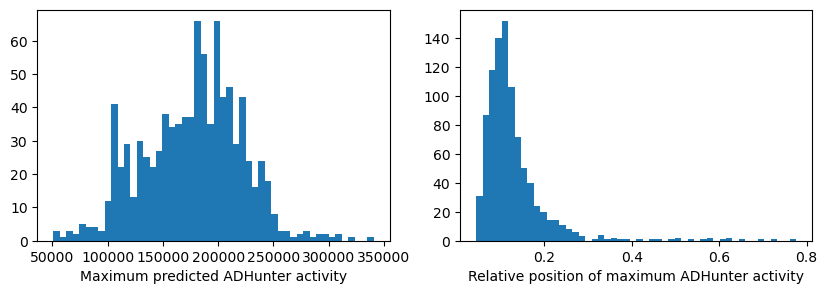

In [26]:
# Visualize location and distribution of maximum activities
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(predictions["max_adhunter_pred"], bins=50)
axs[0].set_xlabel("Maximum predicted ADHunter activity")

axs[1].hist(predictions["max_adhunter_center"]/predictions["Length"], bins=50)
axs[1].set_xlabel("Relative position of maximum ADHunter activity")

In [27]:
# Code to get a 70aa region around the maximum predicted ADHunter activity
def get_high_activity_region(sequence, max_center):
    # If the max activity is 35aa or more away from both ends
    if (len(sequence) >= max_center + 35) & (max_center - 35 >= 0):
        region = sequence[max_center - 35 : max_center + 35]

    # If the max activity is close to the end
    elif (len(sequence) < max_center + 35):
        region = sequence[len(sequence)-70:]

    # If the max activity is close to the beginning
    else:
        region = sequence[:70]
    return region

In [28]:
# Extract AD regions for all sequences
predictions["AD_region"] = [get_high_activity_region(predictions.loc[i, "sequence"], int(predictions.loc[i, "max_adhunter_center"])) for i in predictions.index]

In [29]:
# Merge ADHunter predictions with filtered df
predictions_w_names = met4_filtered_df.merge(predictions.drop_duplicates("sequence"), left_on="aa_seq", right_on="sequence")

In [30]:
# Filter out one of the yeast genes (duplicate with the other cerevisiae genome)
predictions_w_names = predictions_w_names[predictions_w_names["name"] != "YNL103W_saccharomyces_cerevisiae.sgd"].reset_index()

In [31]:
# Make fasta file with only the ADregions
with open("../Met4/Met4_filtered_ADregions.fasta", "w+") as f:
    for i in predictions_w_names.index:
        f.write(">" + predictions_w_names.loc[i, "gene_species_name"] + "\n")
        f.write(predictions_w_names.loc[i, "AD_region"] + "\n")

In [32]:
# Colors for the alignment conservation plots
amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',  # Deep sky blue
    'R': '#00B3E5',  # Blue 

    # black
    'S': '#000000',  # Gainsboro
    'P': '#000000',  # Dim grey

    # greys
    'A': '#787878',  # Lime green
    'V': '#787878',  # Light green
    'I': '#787878',  # Sea green
    'M': '#787878',  # Olive drab
    'T': '#787878',  # Silver
    'G': '#787878',  # Slate grey
    'C': '#787878',  # Burly wood
    'N': '#787878',  # Wheat
    'Q': '#787878',  # Tan
    'H': '#787878',  
    'Y': '#787878', 
    'X': '#787878', 
    '-': "#FFFFFF"
}

In [33]:
# Code to make alignment conservation plots
def make_alignment_conservation_plot(alignment_file, output_file, remove_gaps=False):
    
    # Read in alignment file
    with open(alignment_file, "r") as f:
        lines = f.readlines()

    names = []
    seqs = []
    seq = ""

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">",""))
            if len(seq) > 0:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    # This will determine the position of the amino acid in the plot (i.e. X at the bottom, - at the top)
    amino_acids = ['X', 'Y', 'H', 'Q','N', 'C', 'G', 'T', 'M', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'L', 'W', 'F', '-']

    # List of sequence positions - Each entry is a dictionary with amino acid counts at the position
    amino_acid_dicts = [{aa: 0 for aa in amino_acids}.copy() for _ in range(len(seqs[0]))]

    # Go through each sequence and count the amino acids at each position
    for seq in seqs: 
        for i, aa in enumerate(seq): 
            amino_acid_dicts[i][aa] += 1
    
    if remove_gaps: 
        filtered_aa_dict = []
        for aa_d in amino_acid_dicts:
            # Only include positions that are less than 90% gaps
            if aa_d['-'] < len(seqs) * .90:
                filtered_aa_dict.append(aa_d)
        amino_acid_dicts = filtered_aa_dict

    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(figsize=(20,3))

    for i, count_dict in enumerate(amino_acid_dicts): 
        bottom = 0

        # Add to the bar for each amino acid
        for aa, count in count_dict.items():
            p = ax.bar(i, count/len(seqs), label=aa, bottom=bottom, color = amino_acid_colors[aa])
            bottom += count/len(seqs)

    ax.set_xlabel("Alignment position")
    ax.set_ylabel("Percent of sequences")

    custom_lines = []

    # Code to add a legend
    for color in list(amino_acid_colors.values()):
        custom_lines.append(Line2D([0], [0], color=color, lw=2))

    ax.legend(custom_lines, list(amino_acid_colors.keys()), bbox_to_anchor=(1.05, 1.05), fontsize=5.5)

    plt.savefig(output_file)

In [34]:
! mafft --auto ../Met4/Met4_filtered_ADregions.fasta > ../Met4/Met4_filtered_ADregions.mafft

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  901 / 922
done.

Constructing a UPGMA tree (efffree=0) ... 
  920 / 922
done.

Progressive alignment 1/2... 
STEP   224 / 921 
Reallocating..done. *alloclen = 1143
STEP   901 / 921  h
done.

Making a distance matrix from msa.. 
  900 / 922
done.

Constructing a UPGMA tree (efffree=1) ... 
  920 / 922
done.

Progressive alignment 2/2... 
STEP   311 / 921 
Reallocating..done. *alloclen = 1143
STEP   901 / 921  h
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It ten

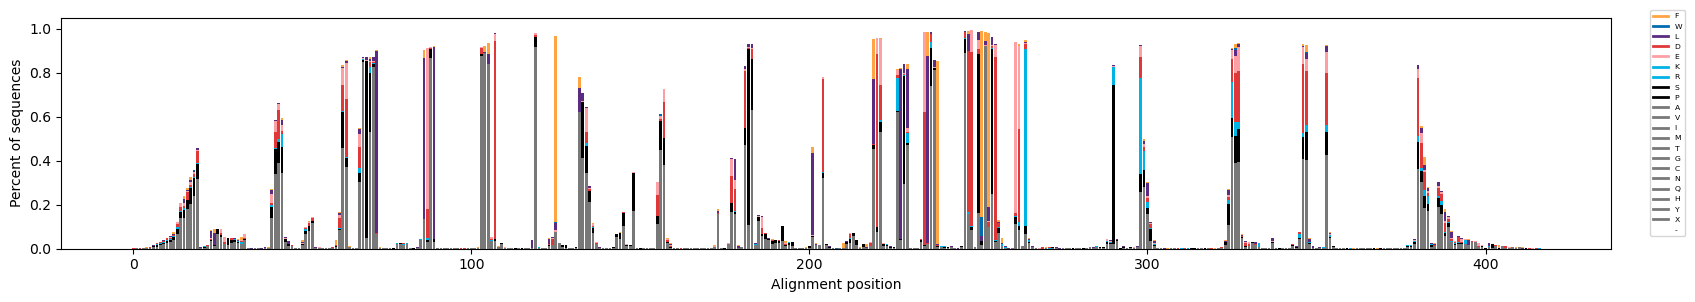

In [35]:
make_alignment_conservation_plot("../Met4/Met4_filtered_ADregions.mafft", "../Met4/Met4_ADregions_alignment_conservation_plot.pdf")

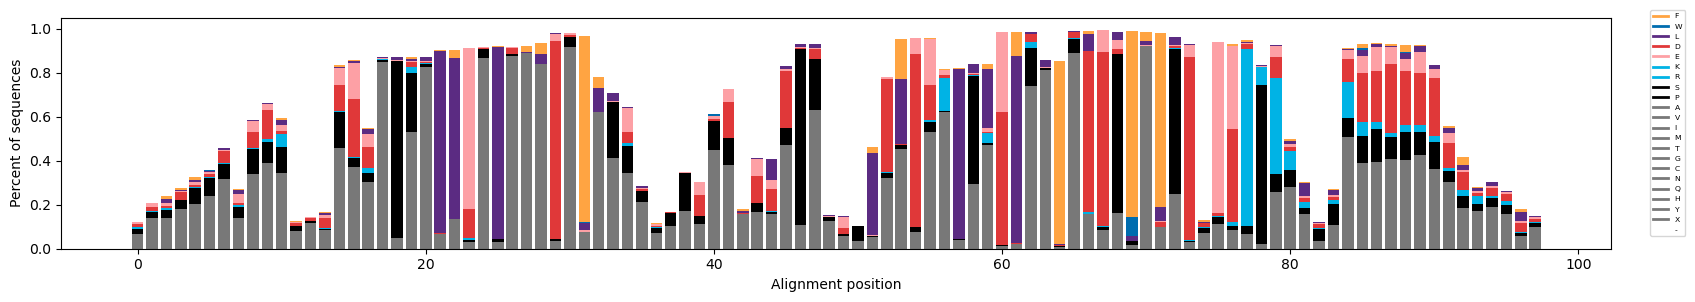

In [36]:
make_alignment_conservation_plot("../Met4/Met4_filtered_ADregions.mafft", "../Met4/Met4_ADregions_alignment_conservation_plot_gaps_removed.pdf", remove_gaps=True)

In [37]:
make_alignment_conservation_plot("../Met4/Met4_blast_filtered.mafft", "../Met4/Met4_full_alignment_conservation_plot.pdf")